# Graph Tool Sanbox

In [2]:
# Mathematical and Data Managment
import numpy as np
import pandas as pd
import scipy.sparse as sp

# Graph Managment
import graph_tool.all as gt
import networkx as nx

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Miscellaneous
import pickle
import json
from glob import glob
from tqdm import tqdm
import random

/mnt/disk2/anaconda3/envs/gt_global/lib/python3.11/site-packages/graph_tool/draw/cairo_draw.py:1544: RuntimeWarning: Error importing Gtk module: ; GTK+ drawing will not work.
  warnings.warn(msg, RuntimeWarning)


Grafo Minimo reproducible similar al grafo grande

This is our toy edge list [(0, 1), (1, 2), (2, 0), (3, 1), (4, 5), (5, 4)]
This are our toy weights [8, 9, 7, 10, 12, 11]


Fontconfig error: Cannot load default config file: No such file: (null)


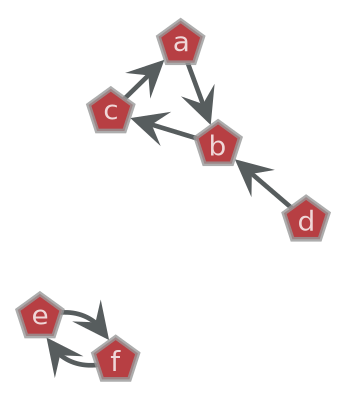

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fa27eb18550, at 0x7fa262e73f10>

In [3]:
# TOY GRAPH FOR CALCULATIONS
random.seed(1)

edge_list = [(0,1),(1,2),(2,0),(3,1),(4,5),(5,4)]
vertex_dict = {
    'label': 'a b c d e f'.split(' '),
    'pa': 'd c d i i i'.split(' '),
    'id': [i for i in range(10000,10006)]
}
color = {
    'i': (0,0,1), # Azul
    'd': (1,0,0), # Rojo
    'c': (0,1,0) # Centro
}
weights = [8,9,7,10,12,11]
g = gt.Graph(directed=True)
print(f'This is our toy edge list {edge_list}')
print(f'This are our toy weights {weights}')

g.add_edge_list(edge_list=edge_list)

# Create an edge property map for weights
edge_weight_map = g.new_edge_property("double")
edge_date_map = g.new_edge_property('string')

# Create a Vertex property map for labels
vertex_PA_map = g.new_vertex_property('string')
vertex_ID_map = g.new_vertex_property('int64_t')
vertex_color_map = g.new_vertex_property('vector<double>')
vertex_label_map = g.new_vertex_property('string')

# Add edges properties
edge_list = g.get_edges()
for i, e in enumerate(edge_list):
    edge_weight_map[e] = weights[i]
    edge_date_map[e] = '2021-05-16'

# Add Vertex properties
vertex_list = g.get_vertices()
for v in vertex_list:
    vertex_PA_map[v] = vertex_dict['pa'][v]
    vertex_ID_map[v] = vertex_dict['id'][v]
    vertex_label_map[v] = vertex_dict['label'][v]
    vertex_color_map[v] = color[vertex_dict['pa'][v]]

# Assign the maps to the Graph Object
g.vp['Political Label'] = vertex_PA_map
g.vp['User ID'] = vertex_ID_map
g.vp['Label'] = vertex_label_map
g.vp['Color'] = vertex_color_map
g.ep['Normal Weights'] = edge_weight_map
g.ep['Ending date'] = edge_date_map

# Create a graph layout and drawing
pos = gt.sfdp_layout(g)

gt.graph_draw(g,
              pos=pos,
              output_size=(200, 200),
              #vertex_fill_color=vertex_color_map, # Uncomment to show Vertex colors
              vertex_text=vertex_label_map,        # Uncomment to show vertex labels
              vertex_shape = 'pentagon')

Filtrar el grafo en función de alguna propidad categorica del nodo. en este caso el espéctro político

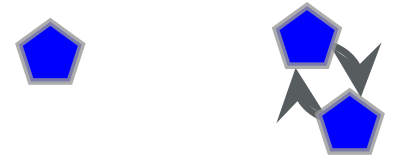

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f40364c07d0, at 0x7f3f75ce82d0>

In [6]:
# Filter edges connected to nodes labeled 'i'
filtered_edges = g.new_edge_property("bool")
filtered_edges.a = False

# Filter nodes with label 'i'
filtered_nodes = g.new_vertex_property("bool")
filtered_nodes.a = False

for v in g.vertices():
    if g.vertex_properties['Political Label'][v] == 'i':
        filtered_nodes[v] = True
        for edge in v.out_edges():
            if g.vertex_properties['Political Label'][edge.target()] == 'i':
                filtered_edges[edge] = True

# Generate the subgraph using the filtered nodes and edges
subgraph = gt.GraphView(g, vfilt=filtered_nodes, efilt=filtered_edges)

gt.graph_draw(subgraph,
              pos=pos,
              output_size=(200, 200),
              vertex_fill_color=vertex_color_map, # Uncomment to show Vertex colors
              #vertex_text=vertex_label_map,        # Uncomment to show vertex labels
              vertex_shape = 'pentagon')

In [7]:
def to_networkx(g: gt.Graph) -> nx.Graph:
    
    if g.is_directed():
        nx_graph = nx.DiGraph()
    else:
        nx_graph = nx.Graph()

    # Add nodes with their properties to the NetworkX graph
    for v in g.vertices():
        node_properties = {prop_name: g.vp[prop_name][v] for prop_name in g.vp}
        nx_graph.add_node(int(v), **node_properties)

    # Add edges with their properties to the NetworkX graph
    for e in g.edges():
        edge_properties = {prop_name: g.ep[prop_name][e] for prop_name in g.ep}
        nx_graph.add_edge(int(e.source()), int(e.target()), **edge_properties)
    
    return nx_graph

In [4]:
def diametros(g: gt.Graph, w = None):
    if w==None:
        weights = None
        name = 'Diametro Simple'
    else:
        weights =g.ep[w]
        name = f'Diametro de {w}'
    diametros= []
    for v in g.vertices():
        d = gt.pseudo_diameter(g, source = v, weights = weights)
        diametros.append(d)

    diametros = pd.DataFrame(diametros, columns = [name, 'Edge'])
    return diametros.drop(columns='Edge').max(axis=0)

In [77]:
diametros(g)

Diametro Simple    3.0
dtype: float64

In [40]:
component_label = g.new_vertex_property('int32_t')
comp = gt.label_components(g,component_label, directed=False)
print(comp[0].a)

[0 0 0 0 1 1]


In [11]:
def descriptive(g: gt.Graph) -> pd.DataFrame:
    # Connected Components 
    SCC, hist = gt.label_components(g, directed=True)
    WCC, hist = gt.label_components(g, directed=False)
    
    N_SCC = len(set(SCC.a))
    N_WCC = len(set(WCC.a))
    
    # Clustering
    weights = g.ep['Normal Weights']
    cluester_coef = gt.global_clustering(g,weight = weights)
    
    # Diameter
    diametro = diametros(g)
    #random_edge = g.edge(random.randint(0, g.num_edges() - 1), random.randint(0, g.num_edges() - 1))
    
    results = {
        #'Date': g.ep['Ending date'][random_edge],
        'Strongly Connected Components': N_SCC,
        'Weakly Connected Components': N_WCC,
        'Global Clustering Coefficient': cluester_coef[0],
        'Diameter': diametro
    }
    return results

descriptive(g)

{'Strongly Connected Components': 3,
 'Weakly Connected Components': 2,
 'Global Clustering Coefficient': 0.17652495378927913,
 'Diameter': Diametro Simple    3.0
 dtype: float64}